(optional)

In [131]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
#os.chdir('...')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [133]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
import tensorflow as tf
from tensorflow.keras import layers, models

In [134]:
data = np.load('data.npz')
label = np.load('label.npz')

In [135]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [136]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [137]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

In [138]:
new_y_train = np.zeros((604,6))
new_y_val = np.zeros((152,6))
for i in range(604):
  new_y_train[i,int(Y_train[i,0])] = 1
for i in range(152):
  new_y_val[i,int(Y_val[i,0])] = 1

In [139]:
print(new_y_train.shape)

(604, 6)


## Model Implementation Part

### LSTM

In [140]:
# Build your model here:
model = models.Sequential()
model.add(layers.LSTM(1000, return_sequences=True, input_shape = (22,200)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(500))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(200, activation = 'relu'))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(6, activation = 'softmax'))


In [141]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 22, 1000)          4804000   
                                                                 
 dropout_26 (Dropout)        (None, 22, 1000)          0         
                                                                 
 lstm_13 (LSTM)              (None, 500)               3002000   
                                                                 
 dropout_27 (Dropout)        (None, 500)               0         
                                                                 
 dense_23 (Dense)            (None, 200)               100200    
                                                                 
 dense_24 (Dense)            (None, 100)               20100     
                                                                 
 dense_25 (Dense)            (None, 6)               

In [142]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [143]:
history = model.fit(X_train, new_y_train, epochs=20, validation_data=(X_val, new_y_val))

Epoch 1/20
19/19 [==============================] - 4s 69ms/step - loss: 1.2536 - accuracy: 0.4636 - val_loss: 0.7618 - val_accuracy: 0.6842
Epoch 2/20
19/19 [==============================] - 0s 23ms/step - loss: 0.4101 - accuracy: 0.8427 - val_loss: 0.5986 - val_accuracy: 0.7895
Epoch 3/20
19/19 [==============================] - 0s 22ms/step - loss: 0.1454 - accuracy: 0.9619 - val_loss: 0.7588 - val_accuracy: 0.7697
Epoch 4/20
19/19 [==============================] - 0s 22ms/step - loss: 0.1345 - accuracy: 0.9619 - val_loss: 0.5537 - val_accuracy: 0.8224
Epoch 5/20
19/19 [==============================] - 0s 22ms/step - loss: 0.0831 - accuracy: 0.9752 - val_loss: 0.5733 - val_accuracy: 0.8224
Epoch 6/20
19/19 [==============================] - 0s 22ms/step - loss: 0.0377 - accuracy: 0.9901 - val_loss: 0.6198 - val_accuracy: 0.8421
Epoch 7/20
19/19 [==============================] - 0s 22ms/step - loss: 0.0156 - accuracy: 0.9983 - val_loss: 0.6458 - val_accuracy: 0.8355
Epoch 8/20
19

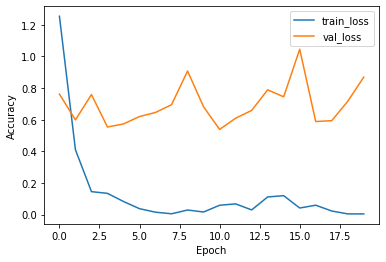

In [144]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

In [145]:
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis = 1)
pred_test = np.reshape(pred_test, (190,1))
pred_test = pred_test.astype(int)

6/6 [==============================] - 1s 7ms/step


In [146]:
output = pred_test
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")

### EEGNet

In [147]:
from keras.constraints import maxnorm

In [148]:
# Build your model here:
C=22
T=200
F1=8
F2=16
D=2
#BLOCK1
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(C,T)))
model.add(layers.Reshape(target_shape=(C,T,1), input_shape=(1,C,T)))
model.add(layers.Conv2D(F1 ,(1,64), padding='same',use_bias = False))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D(kernel_size=(C,1), padding='valid', depth_multiplier=D, depthwise_constraint=tf.keras.constraints.max_norm(1.),use_bias = False))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))
model.add(layers.AveragePooling2D(pool_size=(1,4)))
model.add(layers.Dropout(0.25))

#BLOCK2
model.add(layers.SeparableConv2D(F2,(1,16), padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))
model.add(layers.AveragePooling2D(pool_size=(1,8)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

#CLASSIFIER
model.add(layers.Dense(6, kernel_constraint=tf.keras.constraints.max_norm(0.25), activation='softmax'))

In [149]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 22, 200, 1)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 200, 8)        512       
                                                                 
 batch_normalization_27 (Bat  (None, 22, 200, 8)       32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_9 (Depthwi  (None, 1, 200, 16)       352       
 seConv2D)                                                       
                                                                 
 batch_normalization_28 (Bat  (None, 1, 200, 16)       64        
 chNormalization)                                                
                                                     

In [150]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [151]:
history = model.fit(X_train, new_y_train, epochs=20, validation_data=(X_val, new_y_val))

Epoch 1/20
19/19 [==============================] - 1s 18ms/step - loss: 1.6658 - accuracy: 0.3974 - val_loss: 1.6204 - val_accuracy: 0.5789
Epoch 2/20
19/19 [==============================] - 0s 9ms/step - loss: 1.3181 - accuracy: 0.5861 - val_loss: 1.4597 - val_accuracy: 0.6250
Epoch 3/20
19/19 [==============================] - 0s 9ms/step - loss: 1.1313 - accuracy: 0.7086 - val_loss: 1.3567 - val_accuracy: 0.7697
Epoch 4/20
19/19 [==============================] - 0s 9ms/step - loss: 0.9796 - accuracy: 0.7666 - val_loss: 1.2902 - val_accuracy: 0.8289
Epoch 5/20
19/19 [==============================] - 0s 9ms/step - loss: 0.8860 - accuracy: 0.8377 - val_loss: 1.2099 - val_accuracy: 0.8618
Epoch 6/20
19/19 [==============================] - 0s 9ms/step - loss: 0.8334 - accuracy: 0.8725 - val_loss: 1.1425 - val_accuracy: 0.8684
Epoch 7/20
19/19 [==============================] - 0s 8ms/step - loss: 0.7852 - accuracy: 0.8907 - val_loss: 1.0793 - val_accuracy: 0.8816
Epoch 8/20
19/19 [=

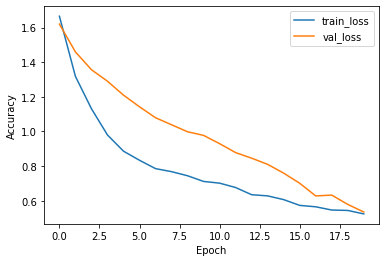

In [152]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

In [153]:
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis = 1)
pred_test = np.reshape(pred_test, (190,1))
pred_test = pred_test.astype(int)

6/6 [==============================] - 0s 2ms/step


In [154]:
output = pred_test
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

## Model Competition Part

In [155]:
# Build your model here:
#Same as EEGNet

In [156]:
output = pred_test
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")